# Wykozystanie metody integrated gradients do wyznaczenia najważniejszych obszarów w diagnozie nowotworu piersi przez sieć neuronową
Na podstawie: [Model interpretability with Integrated Gradients](https://keras.io/examples/vision/integrated_gradients/)

Z wykorzystaniem datasetu: [Breast Cancer Patients MRI's](https://www.kaggle.com/datasets/uzairkhan45/breast-cancer-patients-mris)

# Import bibliotek

In [131]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing.image import ImageDataGenerator
import cv2
import os

# Czytanie danych

In [132]:
labels = ['Sick', 'Healthy']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

train = get_training_data('../input/breast-cancer-patients-mris/Breast Cancer Patients MRI\'s/train')
test = get_training_data('../input/breast-cancer-patients-mris/Breast Cancer Patients MRI\'s/validation')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


In [133]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

# Przygotowywanie danych

In [134]:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

x_train = x_train.reshape(-1, 250,540, 1)
y_train = np.array(y_train)

x_test = x_test.reshape(-1, 250,540, 1)
y_test = np.array(y_test)

def to_rgb(x):
    x_rgb = np.zeros((x.shape[0], 250,540, 3))
    for i in range(3):
        x_rgb[..., i] = x[..., 0]
    return x_rgb

x_train = to_rgb(x_train)
x_test = to_rgb(x_test)

In [135]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen= keras.preprocessing.image.ImageDataGenerator(    rotation_range=15,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

In [136]:
train_generator = train_datagen.flow_from_directory(
    "../input/breast-cancer-patients-mris/Breast Cancer Patients MRI's/train",
    target_size = (224,224),
    batch_size = 4,
    class_mode = 'binary')

validation_generator = val_datagen.flow_from_directory(
    "../input/breast-cancer-patients-mris/Breast Cancer Patients MRI's/validation",
    target_size = (224,224),
    batch_size = 4,
    shuffle=True,
    class_mode = 'binary')

Found 1400 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


# Tworzenie sieci

In [137]:
model = keras.Sequential()
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.GaussianNoise(0.25))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.GaussianNoise(0.25))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 108, 108, 64)      18496     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 106, 106, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 51, 51, 128)      

In [138]:
model.compile(
  loss='binary_crossentropy',
  optimizer=keras.optimizers.Adam(),
  metrics=['accuracy']
)

# Trenowanie

In [139]:
model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    steps_per_epoch= 50
    )

Epoch 1/10
50/50 [==============================] - 29s 565ms/step - loss: 1.0133 - accuracy: 0.4450 - val_loss: 0.6886 - val_accuracy: 0.6000
Epoch 2/10
50/50 [==============================] - 28s 564ms/step - loss: 0.7030 - accuracy: 0.4900 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/10
50/50 [==============================] - 28s 568ms/step - loss: 0.7166 - accuracy: 0.5150 - val_loss: 0.7033 - val_accuracy: 0.5000
Epoch 4/10
50/50 [==============================] - 28s 567ms/step - loss: 0.7071 - accuracy: 0.5550 - val_loss: 0.7041 - val_accuracy: 0.5000
Epoch 5/10
50/50 [==============================] - 29s 578ms/step - loss: 0.7279 - accuracy: 0.4400 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 6/10
50/50 [==============================] - 29s 573ms/step - loss: 0.7102 - accuracy: 0.5400 - val_loss: 0.6926 - val_accuracy: 0.5000
Epoch 7/10
50/50 [==============================] - 28s 567ms/step - loss: 0.7062 - accuracy: 0.5150 - val_loss: 0.6847 - val_accuracy: 0.5000

# Funkcje Gradientów, całkowanych gradientów i losowego szumu

In [140]:
def noise(img,model):

    gradient = []

    for i in range(4):
        noise = np.random.randint(0, 256, size=(250,540,3))
        integrated_gradient = i_gradients(img.astype(np.float32),model,noise.astype(np.float32))
        gradient.append(integrated_gradient)

    gradient = np.mean(gradient,0)
    return gradient
                                           
def i_gradients(img,model,noise):
    
    noise_images = []
    for i in range(40):
        noise_image=noise + (img - noise) * (i / 41)
        noise_images.append(noise_image.astype(np.float32))

    i_gradients = []
    prediction = model.predict(np.expand_dims(img, axis=0))
    prediction = tf.argmax(prediction[0])
    for img in noise_images:
        i_gradient = gradients(img,model,prediction)
        i_gradients.append(i_gradient)
    
    i_gradients = tf.convert_to_tensor(i_gradients, dtype=tf.float32)
    i_gradients_l = i_gradients[:-1]
    i_gradients_r = i_gradients[1:]
    i_gradients = (i_gradients_l + i_gradients_r) / 2
    i_gradients = np.mean(i_gradients,0)

    i_gradients = (img - noise) * i_gradients
    return i_gradients

def gradients(img,model,pred):

    img = tf.expand_dims(img,axis=0)
    with tf.GradientTape() as tape:
        tape.watch(img)
        prediction = model(img)
        result = prediction[:,pred]

    gradients = tape.gradient(result,img)
    gradients = gradients[0]
    return gradients

In [141]:
igrads = noise(
    np.copy(x_test[25]),model)

# Wizualizacja

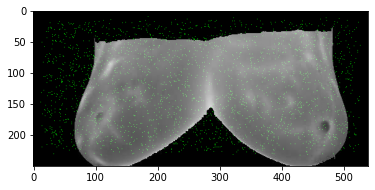

In [142]:
igrads = np.clip(igrads, 0, 1)
igrads = np.average(igrads, axis=2)

attr = np.sort(np.abs(igrads.flatten()))[::-1]

high = attr[np.where(100.0 * np.cumsum(attr) / np.sum(igrads.flatten()) >= 0.1)[0][0]]
low = attr[np.where(100.0 * np.cumsum(attr) / np.sum(igrads.flatten()) >= 9)[0][0]]

attr = (0.8) * (np.abs(igrads) - low) / (high - low) + 0.2
attr = attr * np.sign(igrads)
attr = attr * (attr >= 0.2)

igrads = np.clip(attr, 0.0, 1.0)
igrads = np.expand_dims(igrads, 2) * [0,255,0]
igrads = np.clip((igrads * 0.8 + x_test[25]), 0, 255)

plt.imshow(igrads)
plt.show()